# 关联规则 #

In [1]:
library(arules)
library(recommenderlab)

Loading required package: Matrix


Attaching package: 'arules'


The following objects are masked from 'package:base':

    abbreviate, write


Loading required package: proxy


Attaching package: 'proxy'


The following object is masked from 'package:Matrix':

    as.matrix


The following objects are masked from 'package:stats':

    as.dist, dist


The following object is masked from 'package:base':

    as.matrix


Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy



## eg.1 手机壳交易数据 ##

In [64]:
fp.df <- mlba::Faceplate
fp.mat <- as.matrix(fp.df[, -1])#去掉 Faceplate 数据的第一列并将数据转换为矩阵形式
fp.trans <- as(fp.mat, "transactions")#将矩阵转换为 transactions对象（专门用于关联规则分析的数据结构）
inspect(fp.trans)

     items                    
[1]  {Red, White, Green}      
[2]  {White, Orange}          
[3]  {White, Blue}            
[4]  {Red, White, Orange}     
[5]  {Red, Blue}              
[6]  {White, Blue}            
[7]  {Red, Blue}              
[8]  {Red, White, Blue, Green}
[9]  {Red, White, Blue}       
[10] {Yellow}                 


In [66]:
rules <- apriori(fp.trans, parameter = list(supp = 0.2, conf = 0.5, target = "rules"))#设置最小支持度和置信度挖掘关联规则 
inspect(head(sort(rules, by = "lift"), n = 6))#查看lift值最大的前6条关联规则

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5     0.2      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 2 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[6 item(s), 10 transaction(s)] done [0.00s].
sorting and recoding items ... [5 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [18 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
    lhs               rhs     support confidence coverage lift     count
[1] {Red, White}   => {Green} 0.2     0.5        0.4      2.500000 2    
[2] {Green}        => {Red}   0.2     1.0        0.2      1.666667 2    
[3] {White, Green} => {Red}   0.2     1.0        0.2      1.666667 2    
[4]

## eg.2 书籍购买数据 ##

     items      
[1]  {YouthBks, 
      CookBks}  
[2]  {}         
[3]  {ChildBks, 
      YouthBks, 
      CookBks,  
      RefBks,   
      GeogBks,  
      ItalCook} 
[4]  {}         
[5]  {}         
[6]  {}         
[7]  {GeogBks}  
[8]  {ChildBks} 
[9]  {}         
[10] {CookBks}  


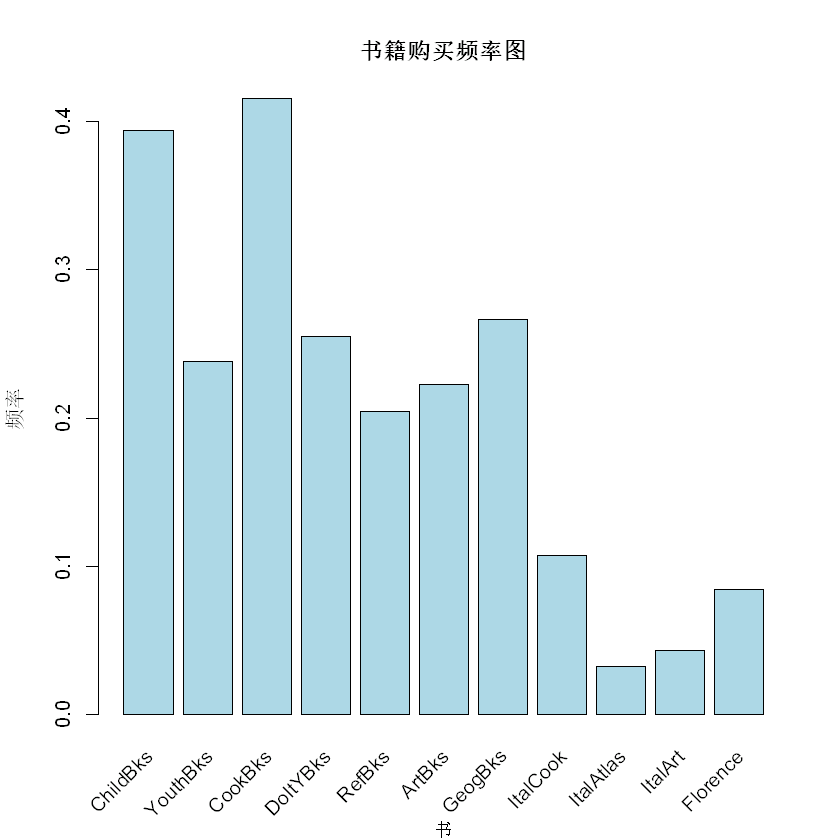

In [2]:
all.books.df <- read.csv("Data/CharlesBookClub.csv")
count.books.df <- all.books.df[, 8:18]#选择8至18列
incid.books.mat <- as.matrix(count.books.df > 0)#书籍被购买则返回逻辑值TRUE
books.trans <- as(incid.books.mat, "transactions")#转换为二元矩阵，并将其转化为transactions对象
inspect(books.trans[1:10])#展示前10条购买记录
itemFrequencyPlot(books.trans,col = "lightblue",main = "书籍购买频率图",  xlab = "书", ylab = "频率" )#绘制各项的购买频率图


In [38]:
rules <- apriori(books.trans,parameter = list(supp= 0.05, conf = 0.5, target = "rules"))#使用apriori挖掘关联规则

inspect(head(sort(rules, by = "lift"), n=30))#展示lift值最大的前30条规则

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5    0.05      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 200 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[11 item(s), 4000 transaction(s)] done [0.00s].
sorting and recoding items ... [9 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [72 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
     lhs                               rhs        support confidence coverage
[1]  {ChildBks, CookBks, GeogBks}   => {YouthBks} 0.06325 0.5776256  0.10950 
[2]  {ChildBks, CookBks, RefBks}    => {DoItYBks} 0.06125 0.5917874  0.10350 
[3]  {DoItYBks, GeogBks}            => {YouthBks} 0.05

# 协同过滤 #

将评分数据转换为一个用户-电影的评分矩阵（ratingMatrix）。每一行代表一个用户，每一列代表一部电影，矩阵中的数值表示用户对该电影的评分。

In [47]:

ratings <- mlba::MovieLensRatings#导入数据
movies <- mlba::MovieLensMovies

idxUserId <- sort(unique(ratings$userId))
idxMovieId <- sort(unique(ratings$movieId))
m <- matrix(NA, nrow=length(idxUserId), ncol=length(idxMovieId),
            dimnames=list(
              user=paste("u", 1:length(idxUserId), sep=''),
              item=movies$title[match(idxMovieId, movies$movieId)]
            ))
for (i in 1:nrow(ratings)) {
  rating <- ratings[i,]
  irow <- match(rating$userId, idxUserId)
  icol <- match(rating$movieId, idxMovieId)
  m[irow, icol] <- rating$rating
}
ratingMatrix <- as(m, "realRatingMatrix")


In [52]:

recommender <- Recommender(ratingMatrix[-1], method="UBCF")#基于用户的协同过滤
pred <- predict(recommender, ratingMatrix[1])
as(pred, 'list')


$`0`
 [1] "Bossa Nova (2000)"           "Maltese Falcon, The (1941)" 
 [3] "Michael Clayton (2007)"      "3-Iron (Bin-jip) (2004)"    
 [5] "Battlestar Galactica (2003)" "Enemy at the Gates (2001)"  
 [7] "Watchmen (2009)"             "Walk to Remember, A (2002)" 
 [9] "Tristan & Isolde (2006)"     "Atonement (2007)"

In [58]:

recommender <- Recommender(ratingMatrix[-1], method="IBCF")#基于物品的协同过滤
pred <- predict(recommender, ratingMatrix[1])
as(pred, 'list')

$`0`
 [1] "NeverEnding Story III, The (1994)"   "Amateur (1994)"                     
 [3] "Mute Witness (1994)"                 "My Crazy Life (Mi vida loca) (1993)"
 [5] "Miami Rhapsody (1995)"               "Pushing Hands (Tui shou) (1992)"    
 [7] "Suture (1993)"                       "Double Happiness (1994)"            
 [9] "Being Human (1993)"                  "Lassie (1994)"

## 评估推荐模型 ##

In [60]:
set.seed(1)
e <- evaluationScheme(ratingMatrix, method="split", train=0.9, given=10)#数据集拆分为90%训练集，10%测试集

r1 <- Recommender(getData(e, "train"), "UBCF")#使用Recommender训练UBCF、IBCF和RANDOM（随机推荐）三个模型
r2 <- Recommender(getData(e, "train"), "IBCF")
r3 <- Recommender(getData(e, "train"), "RANDOM")

p1 <- predict(r1, getData(e, "known"), type="ratings")#预测测试集
p2 <- predict(r2, getData(e, "known"), type="ratings")
p3 <- predict(r3, getData(e, "known"), type="ratings")
error <- rbind(
  UBCF = calcPredictionAccuracy(p1, getData(e, "unknown")),
  IBCF = calcPredictionAccuracy(p2, getData(e, "unknown")),
  RANDOM = calcPredictionAccuracy(p3, getData(e, "unknown"))
)#使用calcPredictionAccuracy函数计算各个模型的预测精度，返回一个误差矩阵
error

,RMSE,MSE,MAE
UBCF,1.155608,1.335429,0.8943074
IBCF,1.314356,1.727531,1.0543478
RANDOM,1.780208,3.169139,1.4539972
